# Setup and Imports

In [2]:
%env CUDA_VISIBLE_DEVICES=7
%cd ..

env: CUDA_VISIBLE_DEVICES=7
/home/erwan/workspace/upf/evodevox


In [3]:
import jax
import jax.random as jr
import jax.numpy as jnp
import numpy as np
import equinox as eqx

import matplotlib.pyplot as plt
import celluloid
from IPython.display import HTML, display

# Creating Agents

In [80]:
body_resolution = 4
body_size = 4.0

### Sensory Model

In [81]:
from src.agents.sensory import SpatiallyEmbeddedSensoryInterface

sensory_interface = SpatiallyEmbeddedSensoryInterface(body_resolution=body_resolution)

### Encoding and Neural model

In [82]:
from src.devo import RAND

def encoding_factory(key):
    """Factory for a RAND encoding model."""
    return RAND(nb_neurons=1, 
                max_neurons=64,
                network_type="ctrnn",
                sensory_genes=8,
                key=key)

Number of neurons: 1


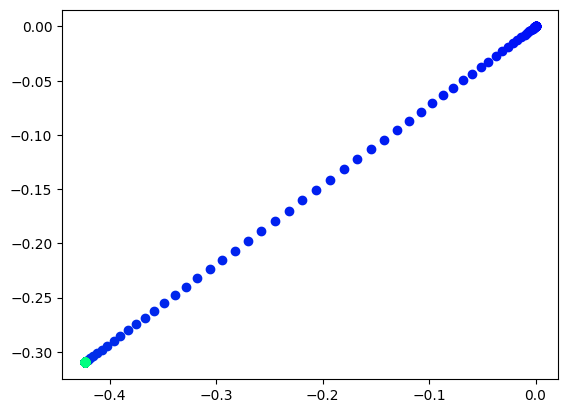

In [83]:
# Let's test a randomly generated RAND

key_mdl, key_init, key_migr = jr.split(jr.key(1001), 3)

encoding_model = encoding_factory(key_mdl)

state = encoding_model.init(key_init)
final_state, data = encoding_model.do_migration(state, key_migr)
xs = data["state"].X
masks = data["state"].mask
print("Number of neurons:", masks[-1].sum())
for t in range(xs.shape[0]):
    plt.scatter(*xs[t, masks[t]].T, color=plt.cm.winter(t/xs.shape[0]))
plt.show()

In [84]:
from src.agents.nn import CTRNNPolicy, make_apply_init

def policy_factory(key):
    return CTRNNPolicy(encoding_model=encoding_factory(key))

# instantiate the policy
policy = policy_factory(jr.key(8))
policy_apply, policy_init = make_apply_init(policy)


### Motor Model

In [85]:
from src.agents.motor import BraitenbergMotorInterface

motor_interface = BraitenbergMotorInterface()

## Create Complete Interface

In [86]:
from src.agents import AgentInterface

policy_prms_fctry = lambda key: eqx.filter(policy_factory(key), eqx.is_array)
agent_interface = AgentInterface(policy_apply=policy_apply,
                                 policy_init=policy_init,
                                 policy_fctry=policy_prms_fctry,
                                 sensory_interface=sensory_interface,
                                 motor_interface=motor_interface,
                                 body_resolution=body_resolution,
                                 min_body_size=2.0,
                                 max_body_size=4.0)

# Create world

We will now create the environment. We will start with a single food species emitting a unique chemical type

In [87]:
import jax.numpy as jnp
from src.eco.gridworld import FoodType, ChemicalType

nb_food_types = 1
nb_chemical_types = 1

food_type = FoodType(growth_rate=jnp.full((nb_food_types,), 0.05 ),
                     dmin=jnp.full((nb_food_types,), 1.0),
                     dmax=jnp.full((nb_food_types,), 2.0),
                     chemical_signature=jnp.full((nb_food_types, nb_chemical_types), 1.0),
                     energy_concentration=jnp.full((nb_food_types,), 1.0),
                     spontaneous_grow_prob=jnp.full((nb_food_types,), 0.0),
                     initial_density=jnp.full((nb_food_types,), 0.01))

chemical_type = ChemicalType(diffusion_rate=jnp.full((nb_chemical_types,), 1.0), 
                             is_sparse=jnp.full((nb_chemical_types,), False), 
                             emission_rate=jnp.full((nb_chemical_types,), 0.0))

In [88]:
from src.eco.gridworld import GridWorld, GridworldConfig, Genotype
from src.evo import GeneralizedMutation

dummy_genotype = Genotype(policy_params=policy_prms_fctry(jr.key(1)), body_size=body_size)
mutation_fn = GeneralizedMutation(sigma=0.03, p_mut=1.0, genotype_like=dummy_genotype, sigma_size=0.0)

cfg = GridworldConfig(size=(64,64),
                      walls_density=0.0,
                      init_agents=8,
                      max_agents=16,
                      max_age=1000, 
                      birth_pool_size=4)

world = GridWorld(cfg, agent_interface, mutation_fn, food_types=food_type, chemical_types=chemical_type, key=jr.key(1))

Now let's simulate our world !

first we initialize it

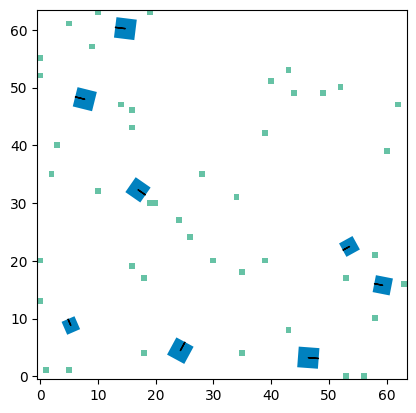

In [89]:
state = world.init(jr.key(1))

world.render(state)
plt.show()

We can inspect the different chemical fields where the first one is the chemicals emitted by agents while the second is emitted by food

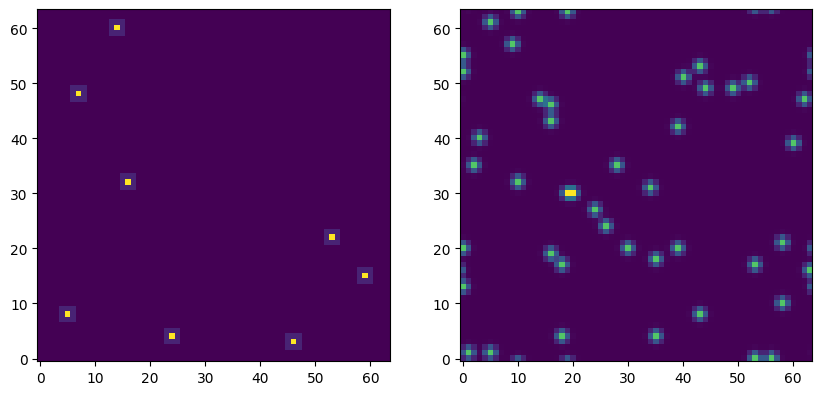

In [15]:
chemical_fields = world._compute_chemical_fields(state, jr.key(1))
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, field in zip(axs, chemical_fields):
    ax.imshow(field.T, origin="lower")
plt.show()

Now let's simulate some steps

In [16]:
state, data = jax.lax.scan(lambda s, k: (world.step(s, k)[0], s), state, jr.split(jr.key(1), 500))

/home/erwan/miniconda3/envs/edx/lib/python3.13/site-packages/jax/_src/ops/scatter.py:110: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=float16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


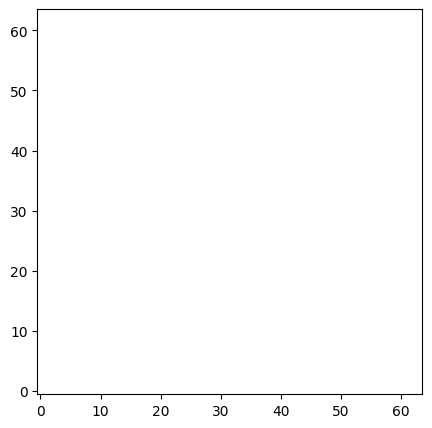

In [17]:
from celluloid import Camera
fig, ax = plt.subplots(figsize=(5,5))
cam = Camera(fig)
cam = world.render_states(data, ax, cam)
ani = cam.animate(interval=60)
display(HTML(ani.to_html5_video()))

We can see that agents are static, that's because we have not found any good developmental program at random.

Now, let's see different types of chemical types:

In [129]:
import jax.numpy as jnp
from src.eco.gridworld import FoodType, ChemicalType

ft1 = FoodType(growth_rate=jnp.full((1,), 0.0 ), #not growing
               dmin=jnp.full((1,), 1.0),
               dmax=jnp.full((1,), 2.0),
               chemical_signature=jnp.ones((1, 3)), # emit all 3 types of chemicals
               energy_concentration=jnp.full((1,), 1.0),
               spontaneous_grow_prob=jnp.full((1,), 0.0),
               initial_density=jnp.full((1,), 0.01))


food_types = ft1

ct1 = ChemicalType(diffusion_rate=jnp.full((1,), 1.0), 
                   is_sparse=jnp.full((1,), False), 
                   emission_rate=jnp.full((1,), 0.0))

ct2 = ChemicalType(diffusion_rate=jnp.full((1,), 10.0), # Higher diffusion rate
                   is_sparse=jnp.full((1,), False), 
                   emission_rate=jnp.full((1,), 1.0))

ct3 = ChemicalType(diffusion_rate=jnp.full((1,), 5.0), 
                   is_sparse=jnp.full((1,), True),  # sparse emission
                   emission_rate=jnp.full((1,), 1.0))

chemical_types = jax.tree.map(lambda a, b, c: jnp.concatenate([a, b, c], axis=0), ct1, ct2, ct3)

In [ ]:
# we can instantiate a wold with the same agent interface and mutation function than before
world = GridWorld(cfg, agent_interface, mutation_fn, food_types=food_types, chemical_types=chemical_types, key=jr.key(10))

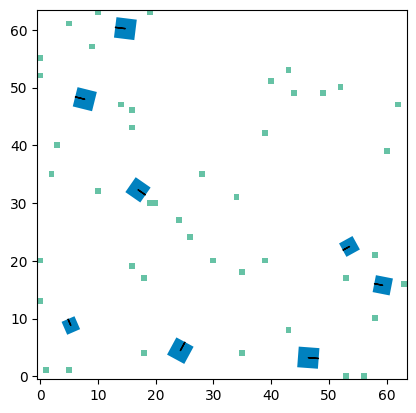

In [131]:
state = world.init(jr.key(1))

world.render(state)
plt.show()

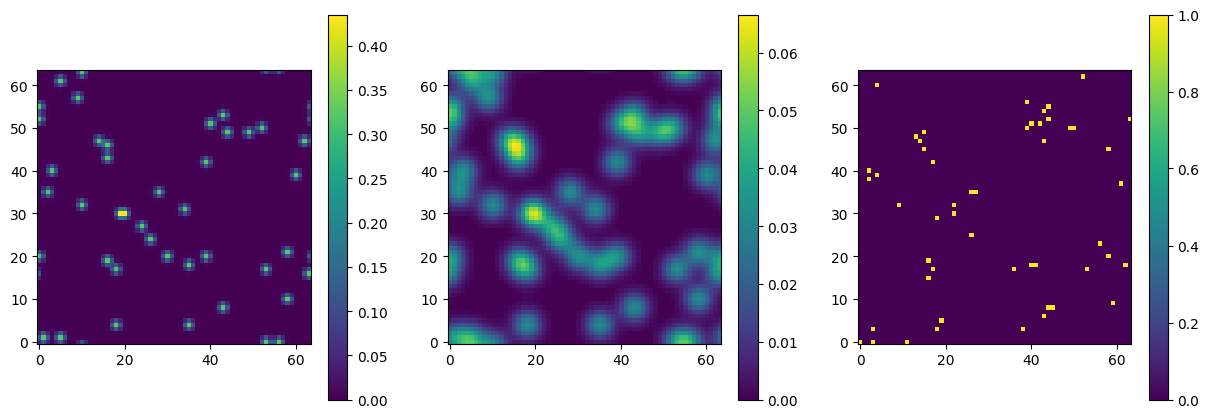

In [139]:
chemical_fields = world._compute_chemical_fields(state, jr.key(1))
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, field in zip(axs, chemical_fields[1:]):
    sc = ax.imshow(field.T, origin="lower")
    plt.colorbar(sc, ax=ax)
plt.show()

We can see that these chemicals provide very different signal landscapes requiring different strategies to navigate!

The "sparse" chemical is intermittent and stochastic, let's see how it evolves through time 

In [133]:
state, states = jax.lax.scan(lambda s, k: (world.step(s, k)[0], s), state, jr.split(jr.key(1), 500))
# compute all chemical fields from all timesteps
chemical_fields = jax.vmap(world._compute_chemical_fields, in_axes=0)(states, jr.split(jr.key(1), 500)) 

/home/erwan/miniconda3/envs/edx/lib/python3.13/site-packages/jax/_src/ops/scatter.py:110: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=float16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


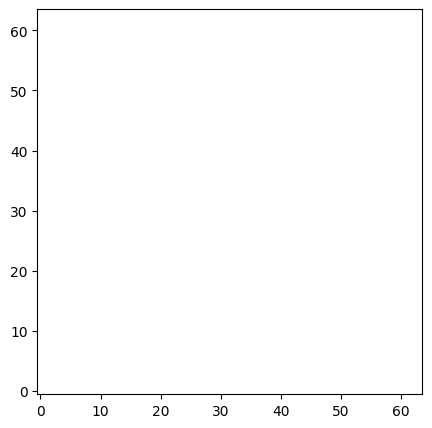

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cam = Camera(fig)

for field in chemical_fields:
    ax.imshow(field[-1].T, origin="lower")
    cam.snap()

anim = cam.animate(interval=50)
display(HTML(anim.to_html5_video()))


If we look at the frequency of signals in each cell we recover the expected signal

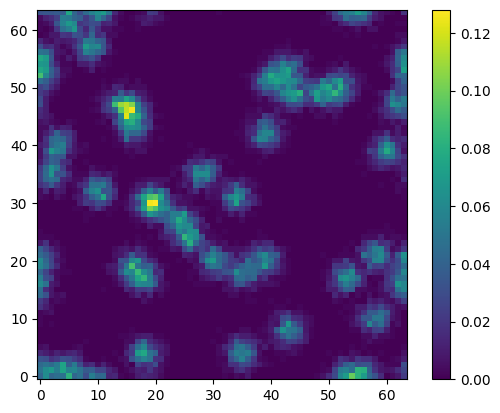

In [136]:
plt.imshow(chemical_fields.mean(0)[-1].T, origin="lower")
plt.colorbar()
plt.show()